# Explaining cortical thickness development: Literature summary

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from os.path import join
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
import matplotlib.patheffects as pe

# working path
wd = os.path.dirname(os.path.realpath("__file__"))
print("Working directory:", wd)

# JuSpyce
sys.path.append(os.path.dirname(join(wd, "scripts", "juspyce")))
from juspyce.api import JuSpyce

# plot directors
plot_dir = join(wd, "plots")

Working directory: /Users/llotter/projects/CTdev


## Get table data

In [2]:
df = pd.read_excel(join(wd, "preprint", "CTdev_suppTables.xlsx"), comment="#", header=[1], 
                   sheet_name="Table S5 - Previous literature")
df = df[~df.isnull().all(axis=1)]
df

,publication,area,topic,process,predictor_association,general_region,specific_region,method,age_start,age_peak,age_end,age_min,age_max
0,"Fung et al., 2010",Cortical Cell Development,CB interneuron proliferation,interneuron marker gene expression increase (CB),NaN,PFC,dlPFC,mRNA expression,0.175,NaN,3.220,0.115385,49.00
1,"Fung et al., 2010",Cortical Cell Development,CB interneuron pruning,interneuron marker gene expression decrease (CB),NaN,PFC,dlPFC,mRNA expression,3.220,NaN,42.605,0.115385,49.00
2,"Fung et al., 2010",Cortical Cell Development,CCK interneuron proliferation,interneuron marker gene expression increase (CCK),NaN,PFC,dlPFC,mRNA expression,0.175,NaN,3.220,0.115385,49.00
3,"Fung et al., 2010",Cortical Cell Development,CR interneuron pruning,interneuron marker gene expression decrease (CR),NaN,PFC,dlPFC,mRNA expression,0.175,NaN,3.220,0.110000,49.22
4,"Fung et al., 2010",Cortical Cell Development,NPY interneuron pruning,interneuron marker gene expression decrease (NPY),NaN,PFC,dlPFC,mRNA expression,3.220,NaN,9.190,0.115385,49.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"Westlye et al., 2010",White Matter Development,WM degeneration,FA decrease and RD/MD decrease,NaN,WM,none,diffusion MRI,65.000,NaN,85.000,8.000000,85.00
95,"Westlye et al., 2010",White Matter Development,WM maturation,FA increase and RD/MD decrease,NaN,WM,none,diffusion MRI,8.000,NaN,30.000,8.000000,85.00
96,"Yeatman et al., 2014",White Matter Development,WM demyelination,R1 decrease,NaN,WM,none,diffusion MRI,40.000,NaN,85.000,7.000000,85.00
97,"Yeatman et al., 2014",White Matter Development,WM maturation,MD decrease,NaN,WM,none,diffusion MRI,7.000,NaN,40.000,7.000000,85.00


## Get our CT-association data

Note: needs to be downloaded from OSF (see first main notebook).

In [83]:
juspyce_ct_dominance = JuSpyce.from_pickle(\
    join(wd, "data_rutherford", f"juspyce_ct_dominance_fm_500_5.pkl.gz"))

# prediction results
ct_dom = juspyce_ct_dominance.predictions["dominance_total"].iloc[1:,:]
ct_dom_sig = juspyce_ct_dominance.p_predictions["dominance_total"].iloc[1:,:]
ct_dom_sig_fdr = juspyce_ct_dominance.p_predictions["dominance_total--fdr_bh"].iloc[1:,:]

for temp in [ct_dom, ct_dom_sig, ct_dom_sig_fdr]:
    temp.index = [np.array(i.split("(")[1].split(",")[0], int)+2.5 for i in temp.index]

# df of significant values
ct_dom_sig = ct_dom_sig < 0.05 # --fdr_bh

# lists of significant predictors
pred_sig = ct_dom_sig.any()
pred_sig = pred_sig[pred_sig==True].index.to_list()
pred_sig_fdr = (juspyce_ct_dominance.p_predictions["dominance_total--fdr_bh"].iloc[1:,:] < 0.05).any()
pred_sig_fdr = pred_sig_fdr[pred_sig_fdr==True].index.to_list()

# pred colors
c_pred = dict(zip(pred_sig, get_cmap("tab10")(range(len(pred_sig)))))

INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_fm_500_5.pkl.gz.


In [84]:
# function to get timepoints significant in a row
def time_period(tp_list):
    tp_sublist1 = [tp_list[0]]
    for i in range(len(tp_list)):
        if i > 0:
            if tp_list[i]-1 == (tp_list[i-1]):
                tp_sublist1.append(tp_list[i])
            else:
                break    
    if len(tp_list)==i+1:
        return tp_sublist1, []
    else: 
        return tp_sublist1, tp_list[i:]
                
# iterate over predictors 
df_this = list()
for pred in pred_sig:
    all_tps = ct_dom_sig[pred][ct_dom_sig[pred]==True].index.to_list()
    
    # extract continuous time periods
    li1, li2 = time_period(all_tps)
    tp_lists = [li1]
    for i in range(1, 10):
        if li2 == []:
            break
        else:
            li1, li2 = time_period(li2)
            tp_lists.append(li1)

    # store data    
    for tp_list in tp_lists:
        df_this.append(pd.DataFrame(dict(
            publication="",
            area="Cortical Thickness Associations (Present Study)",
            pred=pred,
            method="sMRI/mRNA" if pred.startswith("ce") else "sMRI/PET",
            age_start=np.array(tp_list).min(),
            age_peak=ct_dom.loc[tp_list, pred].idxmax(),
            age_end=np.array(tp_list).max(),
            age_min=float(5),
            age_max=float(90)
        ), index=[1]))

# to combined dataframe
df_this = pd.concat(df_this)

# rename predictors
pred_rename = {
    "ni3-FDOPA-DAT-D1-NMDA": "Glutamatergic/dopaminergic, NMDA/DAT $(ni3–FDOPA–DAT–D1–NMDA)$",
    "ni4-GI-5HT1b-MU-A4B2": "Aerobic glycolysis, GI $(ni4–GI–5HT1b–MU–A4B2)$",
    'ni5-VAChT-NET': "Cholinergic, VACht/A4B2 $(ni5–VAChT–NET)$",
    'ni6-CBF-CMRglu': "Oxidative phosphorylation, CBF $(ni6–CBF–CMRglu)$",
    "ni9-D2": "Dopaminergic, D1/2 $(ni9–D2)$",
    'ce3-Micro-OPC': "Microglia $(ce3–Micro–OPC)$",
    'ce4-In3-In2-Astro': "Layer 6 VIP-expressing interneurons, In3/2 $(ce4–In3–In2–Astro)$",
    'ce5-In6-Ex2': "Layer 3/4 granule neurons, Ex2 $(ce5–In6–Ex2)$",
    'ce9-In8': "Layer 6 ST-expressing interneurons $(ce9–In8)$"    
}
df_this["topic"] = df_this.pred.replace(pred_rename)
# merge
df_merged = pd.concat([df, df_this])
#df_merged["predictor_association"] = df_merged["predictor_association"].replace(pred_rename)
# rename secondary sources area
df_merged.area = df_merged.area.replace(
    {"Cortical Thickness Associations": "Cortical Thickness Associations (Literature)"}
)

## Plot function

In [85]:
def braindev_fig(fig, ax, area, color_dict, alpha=0.8, sort="topic"):

    # data
    df_area = df_merged.query("area==@area")
    if sort=="topic":
        df_area = df_area.sort_values("topic", ascending=True).reset_index(drop=True)
    elif sort=="start":
        df_area = df_area.sort_values(["age_start", "age_end"], ascending=True) \
            .reset_index(drop=True)        
    topics = df_area.topic.unique().tolist()
    n_rows = sum([len(df_area.query("topic==@t").publication.unique())+2 for t in topics])
    
    # plot
    idx = n_rows
    for i_topic, topic in enumerate(topics):
        df_topic = df_area.query("topic==@topic").reset_index(drop=True)  
        # label
        ax.annotate(topic, xy=(-2.5,idx-0.75), va="center", ha="left", size=12,
                    c=c_pred[df_topic.pred.values[0]] if "Present Study" in area else "k",
                    weight="semibold")
        idx -= 2
        pubs = df_topic.publication.unique()
        for i_pub, pub in enumerate(pubs):
            df_pub = df_topic.query("publication==@pub")
            for i_row, row in df_pub.iterrows():
                # covered age span
                ax.errorbar(
                    x=row.age_min, 
                    y=(idx),
                    xerr=np.array([[0,row.age_max-row.age_min]]).T,
                    fmt="none",
                    c="k",
                    linewidth=2)
                # estimated process age span
                ax.plot(
                    (row.age_start, row.age_end), 
                    (idx, idx),
                    linewidth=10,
                    zorder=100,
                    color=color_dict[row.method],
                    #path_effects=[pe.Stroke(linewidth=12, foreground='k', alpha=0.9), pe.Normal()],
                    alpha=alpha,
                    solid_capstyle="butt")
                ax.plot(
                    row.age_peak, 
                    idx,
                    zorder=110,
                    color=color_dict[row.method],
                    markeredgecolor="k",
                    alpha=1,
                    markersize=15,
                    marker="o")
                # label
                ax.annotate(
                    pub,
                    xy=(row.age_max+1, idx),
                    va="center",
                    c="k"
                )  
                
                # significance labels
                if "Present Study" in area:
                    if df_topic.pred.values[0] in pred_sig:
                        p = "☆"
                    if df_topic.pred.values[0] in pred_sig_fdr:
                        p = "★"
                    ax.annotate(
                        p,
                        xy=(row.age_max+1, idx),
                        va="center",
                        c=color_dict[row.method],
                        size=20
                    )
                    
            idx -= 1        
    
    # details
    ax.set_title(area, size=13, weight="semibold", loc="left")
    ax.set_xlabel("Postnatal lifespan [years]", size=12)
    ax.set_xticks(np.arange(0,105,10))
    ax.set_yticks([])
    ax.set_ylim(0,n_rows)
    ax.set_xlim(-2.5,102.5)
    ax.xaxis.set_minor_locator(MultipleLocator(5))    
    ax.grid(True, which="major", axis="x", alpha=0.5)
    ax.grid(True, which="minor", axis="x", alpha=0.1)
    [ax.spines[side].set_visible(False) for side in ["left", "top", "right"]]

    # finished
    return fig


## Function to add developmental stages (aligned to CT change period mean, e.g. delta(5,10) = 7.5)
def add_stages(ax, height=0.09, y_upper=-0.06, y_label=-0.4):
    
    # extra axis
    ax_stages = ax.inset_axes((0, 0 + y_upper - height, 1, height))
    ax_stages.set_xlim(ax.get_xlim())
    ax_stages.set_ylim(0,1)
    ax_stages.set_axis_off()
    
    # full lines
    [ax_stages.axvline(x, c="0.3", lw=1) for x in [1, 12, 20, 100]]
    # half lines
    [ax_stages.axvline(x, c="0.3", lw=1, ymin=0.6) for x in [6, 40, 60]]
    # headings
    for s, x in zip(["Childhood", "Adulthood"], [np.mean([1,12]), np.mean([20,100])]):
        ax_stages.text(x=x, y=0.25, s=s, ha="center", va="center")
    # subheadings
    for s, x in zip(["Early", "Late", "Adoles.", "Young", "Middle", "Late"], 
                    [np.mean([1,6]), np.mean([6,12]), np.mean([12,20]), np.mean([20,40]), np.mean([40,60]), np.mean([60,100])]):
        ax_stages.text(x=x, y=0.5 if "Adol" in s else 0.75, s=s, ha="center", va="center")
    # label
    ax_stages.text(
        s="Postnatal lifespan $[years]$",
        x=50,
        y=y_label,
        size=12,
        ha="center",
        va="center"
    )

    return ax_stages


## Cortical thickness associations

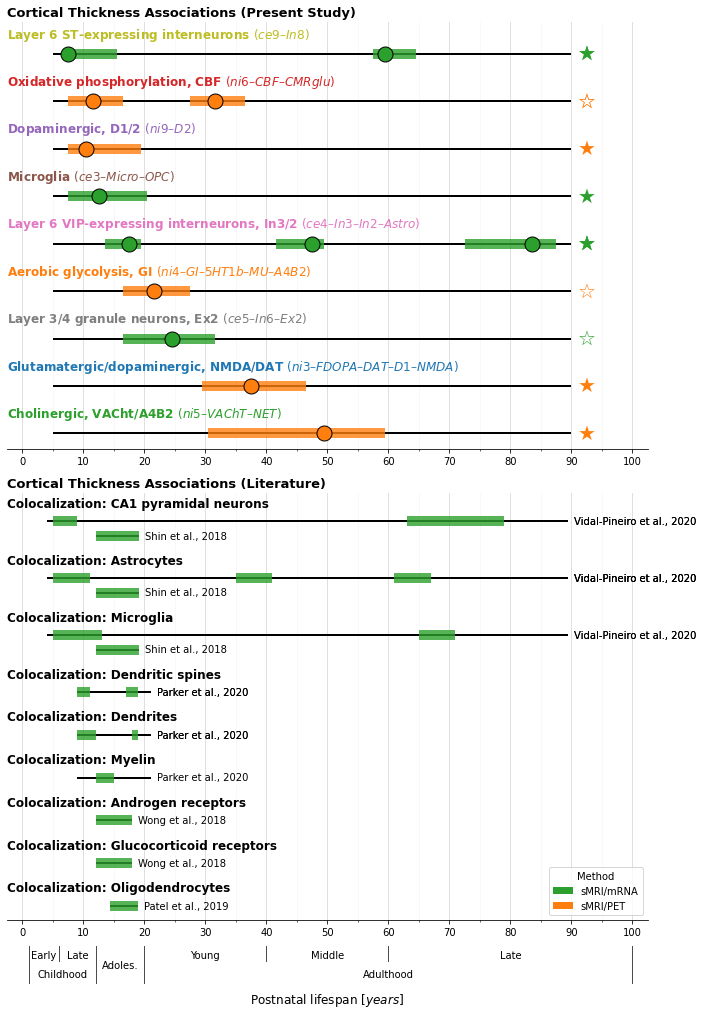

In [86]:
areas_main = [
    "Cortical Thickness Associations (Present Study)", 
    "Cortical Thickness Associations (Literature)"]

# colors
colors_dict = {
    "sMRI/mRNA": get_cmap("tab10")(2),
    "sMRI/PET": get_cmap("tab10")(1)
}

# plot
fig, axes = plt.subplots(2,1, figsize=(10, 14), gridspec_kw=dict(height_ratios=(1,1)))
for i, area in enumerate(areas_main):
    braindev_fig(fig, axes[i], area, colors_dict, sort="start")
    
# stages
ax_stages = add_stages(axes[1])

# legend
legend_items = list()
for method in df_merged.query("area in @areas_main").method.unique():
    legend_items.append(Patch(facecolor=colors_dict[method], label=method))
axes[1].legend(handles=legend_items, title="Method", loc="lower right", ncol=1)

# layout
axes[0].set_xlabel("")
axes[1].set_xlabel("")

# finalize
plt.tight_layout()
plt.savefig(join(plot_dir, "literature", "dev_literature_main.pdf"), bbox_inches="tight")

## Other systems

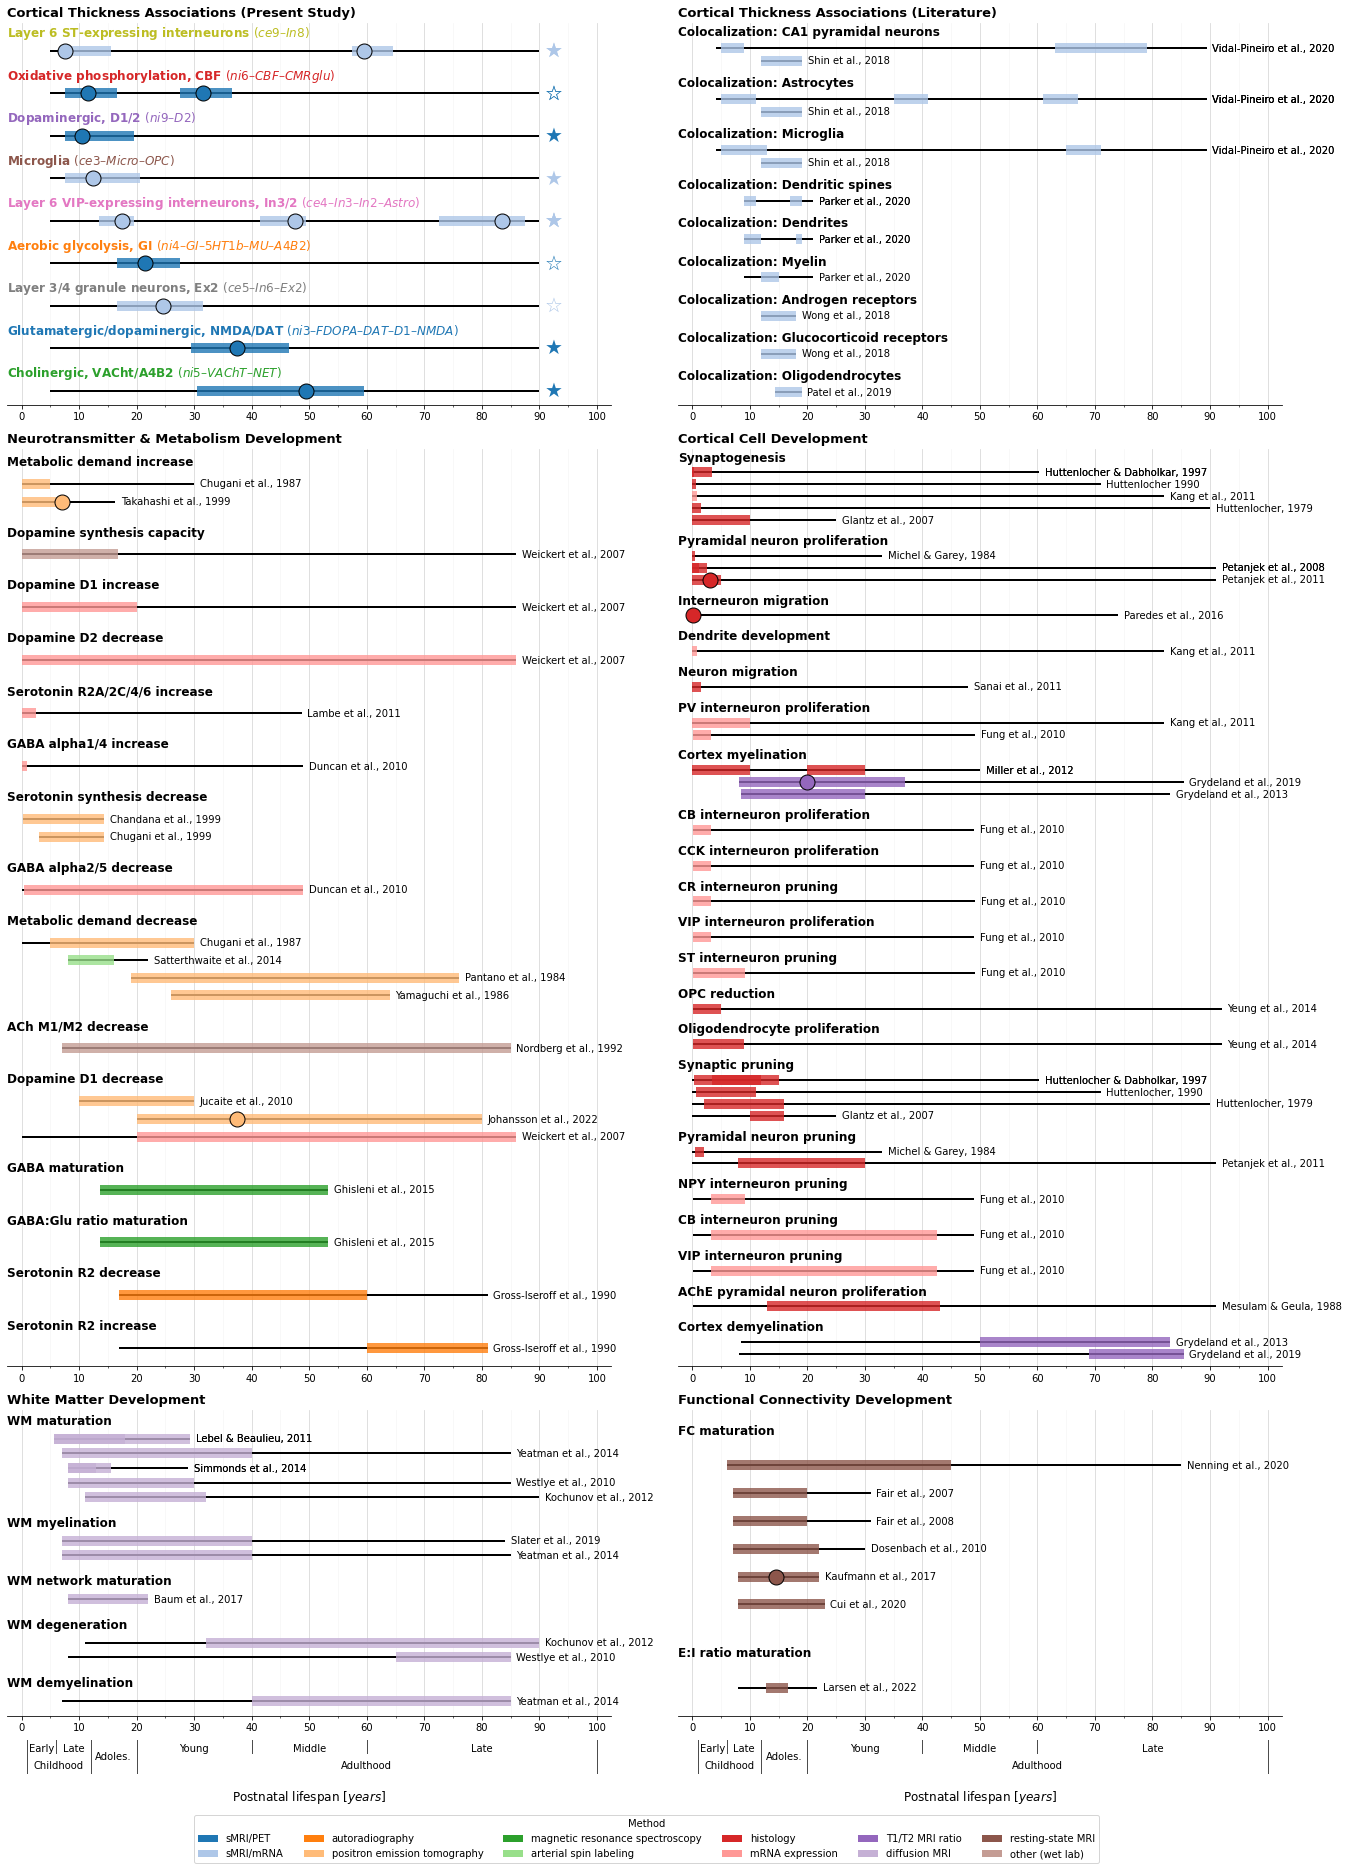

In [87]:
areas = ["Cortical Thickness Associations (Present Study)", 
         "Cortical Thickness Associations (Literature)", 
         "Neurotransmitter & Metabolism Development", "Cortical Cell Development", 
         "White Matter Development", "Functional Connectivity Development"]

# colors
methods = [
    'sMRI/PET',
    'sMRI/mRNA',
    'autoradiography',
    'positron emission tomography',
    'magnetic resonance spectroscopy',
    'arterial spin labeling',
    'histology',
    'mRNA expression',
    'T1/T2 MRI ratio',
    'diffusion MRI',
    'resting-state MRI',
    'other (wet lab)'
]
colors_methods = get_cmap("tab20")(range(len(methods)))
colors_dict = {method: colors_methods[i] for i, method in enumerate(methods)}

# plot
fig, axes = plt.subplots(3,2, figsize=(19, 25), gridspec_kw=dict(height_ratios=(0.5, 1.2, 0.4)))
axes = axes.ravel()
for i, area in enumerate(areas):
    braindev_fig(fig, axes[i], area, colors_dict, alpha=0.8, sort="start")
    axes[i].set_xlabel("")
    if i>=4:
        add_stages(axes[i], height=0.11, y_upper=-0.08, y_label=-0.7)

# legend
legend_items = list()
for method in methods:
    legend_items.append(Patch(facecolor=colors_dict[method], label=method))
fig.legend(handles=legend_items, title="Method",  
        bbox_to_anchor=(0.475, -0.04), loc="lower center", ncol=6)
plt.tight_layout()

plt.savefig(join(plot_dir, "literature", "dev_literature_all.pdf"), bbox_inches="tight")
plt.show()

## Associations to present findings

In [88]:
def plot_span(ax, idx, age_min, age_max, age_start, age_end, color, age_peak, label, alpha=0.8):
    # covered age span
    ax.errorbar(
        x=age_min, 
        y=(idx),
        xerr=np.array([[0, age_max-age_min]]).T,
        fmt="none",
        c="k",
        linewidth=2,
        zorder=100
    )
    # estimated process age span
    ax.plot(
        (age_start, age_end), 
        (idx, idx),
        linewidth=10,
        zorder=90,
        color=color,
        alpha=alpha,
        solid_capstyle="butt"
    )
    ax.plot(
        age_peak, 
        idx,
        zorder=110,
        color=color,
        markeredgecolor="k",
        alpha=1,
        markersize=15,
        marker="o"
    )
    # label
    ax.annotate(
        label,
        xy=(age_max+1, idx),
        va="center",
        c="k",
        weight="semibold" if "present study" in label.lower() else None
    ) 

0 General cortical development
0 Synaptogenesis
1 Pyramidal neuron proliferation
2 Synaptic pruning
3 Colocalization: CA1 pyramidal neurons
4 Pyramidal neuron pruning
5 Colocalization: Dendritic spines
6 Colocalization: Dendrites
1 ce9-In8
0 ST interneuron pruning
2 ni6-CBF-CMRglu
0 Metabolic demand increase
1 Metabolic demand decrease
0 ni9-D2
0 Dopamine D1 increase
1 Dopamine D2 decrease
2 Dopamine D1 decrease
1 ce3-Micro-OPC
0 Cortex myelination
1 Colocalization: Microglia
2 Colocalization: Myelin
2 ce4-In3-In2-Astro
0 VIP interneuron pruning
3 ni4-GI-5HT1b-MU-A4B2
4 ce5-In6-Ex2
5 ni3-FDOPA-DAT-D1-NMDA
6 ni5-VAChT-NET
0 ACh M1/M2 decrease
1 AChE pyramidal neuron proliferation


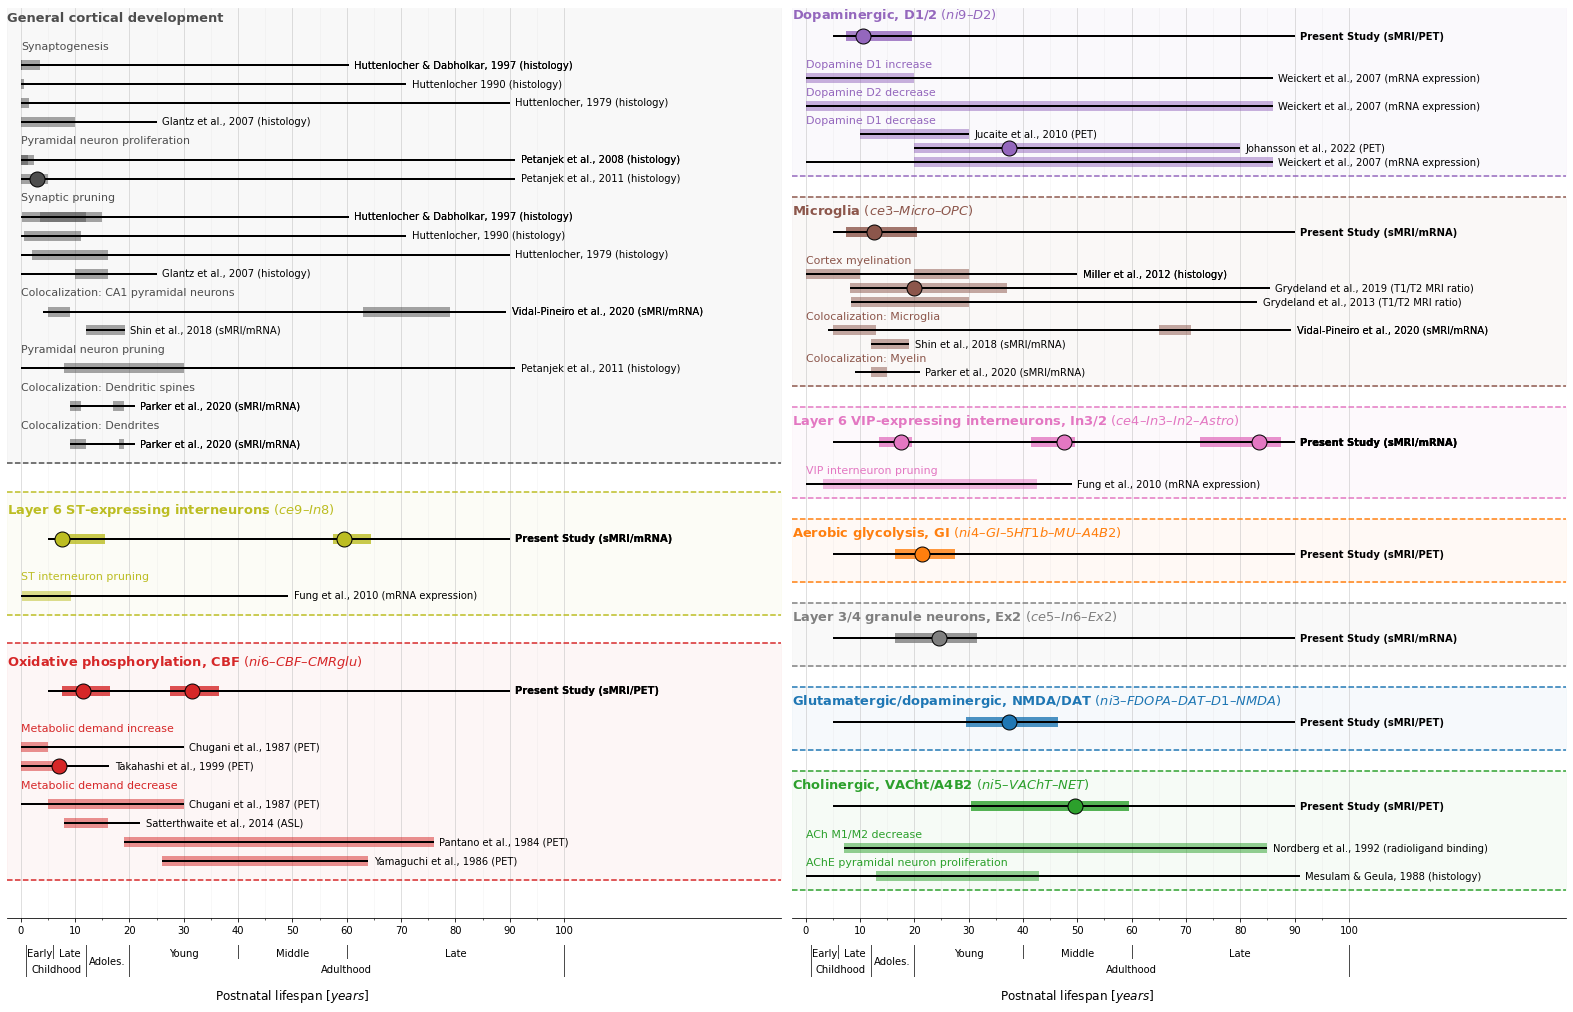

In [94]:
df_merged.loc[df_merged.area=="Cortical Thickness Associations (Present Study)", "publication"] = \
    "Present study"
df_merged = df_merged.replace({
    "positron emission tomography": "PET",
    "other (wet lab)": "radioligand binding",
    "arterial spin labeling": "ASL"
})

c_pred["General cortical development"] = "0.3"

# plot
fig, axes = plt.subplots(1, 2, figsize=(22, 14))

topics_main_all = df_merged[df_merged.area=="Cortical Thickness Associations (Present Study)"] \
    .sort_values(["age_start", "age_end"]).pred.unique().tolist()
topics_main_split = 2
    
for c, topics_main in enumerate([
    ["General cortical development"] + topics_main_all[:topics_main_split], 
    topics_main_all[topics_main_split:]
]):

    ax = axes[c]    
    idx = 0

    for i_tm, topic_main in enumerate(topics_main):
        print(i_tm, topic_main)
        
        df_topic_main = df_merged.query("pred==@topic_main").reset_index(drop=True)  
        
        df_topic_sub = df_merged[df_merged.predictor_association==topic_main] \
            .sort_values(["age_start", "age_end"], ascending=True).reset_index(drop=True)  
        topics_sub = df_topic_sub.topic.unique().tolist()
        
        box_min = idx
        ax.annotate(
            pred_rename[topic_main] if topic_main!="General cortical development" else topic_main, 
            xy=(-2.5, idx+0.5),
            va="center", 
            ha="left", 
            size=13,
            c=c_pred[topic_main],
            weight="semibold"
        )
        idx +=2
        
        if topic_main!="General cortical development":
            for i_tm_sub in range(df_topic_main.shape[0]):
                plot_span(
                    ax=ax, 
                    idx=idx, 
                    age_min=df_topic_main.age_min[i_tm_sub], 
                    age_max=df_topic_main.age_max[i_tm_sub], 
                    age_start=df_topic_main.age_start[i_tm_sub], 
                    age_end=df_topic_main.age_end[i_tm_sub], 
                    age_peak=df_topic_main.age_peak[i_tm_sub],
                    color=c_pred[topic_main], 
                    label=f"Present Study ({df_topic_main.method.values[i_tm_sub]})"
                )
            idx +=2
        
        
        for i_ts, topic_sub in enumerate(topics_sub):
            print(i_ts, topic_sub)
            
            ax.annotate(
                topic_sub, 
                xy=(0, idx),
                va="center", 
                ha="left", 
                size=11,
                c=c_pred[topic_main],
            )
            idx +=1
            
            topics_sub_equal = df_topic_sub.query("topic==@topic_sub").topic.unique().tolist()
            
            for topic_sub_equal in topics_sub_equal:
                
                df_topic_sub_equal = df_topic_sub.query("topic==@topic_sub_equal")
                
                for p in df_topic_sub_equal.publication.unique():
                    
                    df_topic_sub_equal_pub = df_topic_sub_equal.query("publication==@p")
                    
                    for i_p in range(df_topic_sub_equal_pub.shape[0]):
                        
                        plot_span(
                            ax=ax, 
                            idx=idx, 
                            age_min=df_topic_sub_equal_pub.age_min.values[i_p], 
                            age_max=df_topic_sub_equal_pub.age_max.values[i_p], 
                            age_start=df_topic_sub_equal_pub.age_start.values[i_p], 
                            age_end=df_topic_sub_equal_pub.age_end.values[i_p], 
                            age_peak=df_topic_sub_equal_pub.age_peak.values[i_p],
                            color=c_pred[topic_main], 
                            label=f"{df_topic_sub_equal_pub.publication.values[i_p]} "
                                  f"({df_topic_sub_equal_pub.method.values[i_p]})",
                            alpha=0.5
                        )
                    idx +=1  
                    
        ax.axhline(box_min - 0.5, c=c_pred[topic_main], ls="--")
        ax.axhline(idx, c=c_pred[topic_main], ls="--")   
        ax.fill_between(
            x=(-2.5,140),
            color=c_pred[topic_main],
            alpha=0.04,
            y1=box_min - 0.5,
            y2=idx,
            zorder=-20
            
        )
        idx +=2
        
    # details
    #ax.set_title("Summary", size=13, weight="semibold", loc="left")
    #ax.set_xlabel("Postnatal lifespan [years]", size=12)
    ax.set_xticks(np.arange(0,105,10))
    ax.set_xticks(np.arange(0,105,5), minor=True)
    ax.set_yticks([])
    ax.set_ylim(idx, 0)
    ax.set_xlim(-2.5,140)
    #ax.xaxis.set_minor_locator(MultipleLocator(5))    
    ax.grid(True, which="major", axis="x", alpha=0.5)
    ax.grid(True, which="minor", axis="x", alpha=0.1)
    [ax.spines[side].set_visible(False) for side in ["left", "top", "right"]]
    add_stages(ax, height=0.035, y_upper=-0.03, y_label=-0.6)
plt.tight_layout()
plt.savefig(join(plot_dir, "literature", "dev_literature_main_alt.pdf"), bbox_inches="tight")